# Лабораторная работа  "Подсчет кэш-промахов"

### 1. Определим параметры кэшей CPU c помощью утилиты cpuinfo_x86:

```
...
# Caches
## L1 Instruction Cache
Size                  : 32K
Line Size             : 64B
Sharing               : shared between 2 processor threads
Sets                  : 64
Partitions            : 1
Associativity         : 8

## L1 Data Cache
Size                  : 32K
Line Size             : 64B
Sharing               : shared between 2 processor threads
Sets                  : 64
Partitions            : 1
Associativity         : 8

## L2 Unified Cache
Size                  : 256K
Line Size             : 64B
Sharing               : shared between 2 processor threads
Sets                  : 512
Partitions            : 1
Associativity         : 8

## L3 Unified Cache
Size                  : 3M
Line Size             : 64B
Sharing               : shared between 16 processor threads
Sets                  : 4096
Partitions            : 1
Associativity         : 12
...
```

### 2. Определим параметры десктопа.
Параметры CPU:

``` 
# Identification
Vendor                : GenuineIntel
Brand String          : Intel(R) Core(TM) i5-4258U CPU @ 2.40GHz
Model Number          : 69
Family Code           : 6
Extended Model        : 4
Extended Family       : 0
Stepping ID           : 1
Signature             : 263761

# Address Bits
Physical Addressing   : 39
Virtual Addressing    : 48

# Multi-Core Information
Logical Processors (Threads) per Physical Processor : 16
Cores per Physical Package                          : 8
```


Общие параметры:

<img src="https://raw.githubusercontent.com/aliaksei-kasiyanik/cache-miss-lab/master/img/system_info_mac.png" width="600">

### 3. Код анализа количества кэш промахов

[main.cpp](src/main.cpp)

```cpp
class Cache {
    public:
        long long hitCounter = 0;
        long long missCounter = 0;

        Cache(int cacheLineSize, int channels, int size) : cacheLineSize(cacheLineSize), channels(channels),
                                                           size(size) {
            totalLinesInCache = size / cacheLineSize;
            linesInChannel = totalLinesInCache / channels;

            cout << "cache size " << size << " B" << endl;
            cout << "channels " << channels << endl;
            cout << "cacheLineSize " << cacheLineSize << " B" << endl;
            cout << "totalLinesInCache " << totalLinesInCache << endl;
            cout << "linesInChannel " << linesInChannel << endl;

            cache = new long long[totalLinesInCache];
            lastAccessTime = new long long[totalLinesInCache];
            for (int i = 0; i < totalLinesInCache; i++) {
                cache[i] = -1;
                lastAccessTime[i] = -1;
            }
        }

        virtual ~Cache() {
            delete[] cache;
            delete[] lastAccessTime;

        }

        void access(long long addrInMem) {
            long long lineNumberInMem = getCacheLineNumber(addrInMem);
            int lineTag = (int) (lineNumberInMem % linesInChannel);

            if (isCacheContain(lineTag, lineNumberInMem)) {
                hitCounter++;
            } else {
                missCounter++;
                addLineToCache(lineTag, lineNumberInMem);
            }
            return;
        }

    private:
        int cacheLineSize;
        int channels;
        int size;

        int linesInChannel;
        int totalLinesInCache;

        long long *cache;
        long long *lastAccessTime;

        long long getCurrentTimestamp() {
            return chrono::system_clock::now().time_since_epoch().count();
        }

        bool isCacheContain(int cacheLineTag, long long cacheLineNumberInMem) {
            for (int i = 0; i < channels; i++) {
                long n = cacheLineTag * channels + i;
                if (cache[n] == cacheLineNumberInMem) {
                    lastAccessTime[n] = getCurrentTimestamp();
                    return true;
                }
            }
            return false;
        }

        void addLineToCache(int cacheLineTag, long long cacheLineNumberInMem) {
            long lruLineNum = cacheLineTag * channels;
            long minAccessTime = lastAccessTime[lruLineNum];
            for (int i = 1; i < channels; i++) {
                long n = cacheLineTag * channels + i;
                if (lastAccessTime[n] < minAccessTime) {
                    minAccessTime = lastAccessTime[n];
                    lruLineNum = n;
                }
            }

            cache[lruLineNum] = cacheLineNumberInMem;
            lastAccessTime[lruLineNum] = getCurrentTimestamp();
        }

        long long getCacheLineNumber(long long addrInMem) {
            return addrInMem / cacheLineSize;
        }
    };

```

### 4. Графики сравнения количества кэш-промахов, предсказанных valgrind и собственным анализатором

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def parse_valgrind_results(path):
    def _retrieve_refs_metric(str_line):
        return int(str_line.split()[4][1:].replace(",", ""))
    
    def _retrieve_misses_metric(str_line):
        return int(str_line.split()[5].replace(",", ""))
    
    def _retrieve_miss_rate(str_line):
        return float(str_line.split()[6].replace("%", ""))


    result = {}
    metrics = {}
    n = 0

    for line in open(path):
        if line.startswith("n ="):
            n = int(line[3:].strip())
        elif "D" in line and "refs" in line:
            metrics["refs"] = _retrieve_refs_metric(line)
        elif "D1" in line and "misses" in line:
            metrics["misses"] = _retrieve_misses_metric(line)    
        elif "D1" in line and "miss rate" in line:
            metrics["rate"] = _retrieve_miss_rate(line)
            result[n] = metrics
            metrics = {}
            
    return result


def parse_my_results(path):
    def _retrieve_refs_metric(str_line):
        return int(str_line.split()[4][1:].replace(",", ""))
    
    def _retrieve_misses_metric(str_line):
        return int(str_line.split()[5].replace(",", ""))
    
    def _retrieve_miss_rate(str_line):
        return float(str_line.split()[6].replace("%", ""))


    result = {}
    metrics = {}
    n = 0

    for line in open(path):
        if line.startswith("n ="):
            n = int(line[3:].strip())
        elif line.startswith("TOTAL"):
            metrics["refs"] = int(line.split()[1].strip())
        elif line.startswith("MISS %"):
            metrics["rate"] = float(line.split()[2].strip())
            result[n] = metrics
            metrics = {}
        elif line.startswith("MISS"):
            metrics["misses"] =  int(line.split()[1].strip())
            
    return result

In [3]:
valgr_results = parse_valgrind_results("../valgr_log.txt")
my_results = parse_my_results("../my_log.txt")

In [69]:
def generate_plot(valgrind_res, my_res, metric):
    keys = sorted(list(valgrind_res.keys()))
    
    valgr_values = [valgrind_res[key][metric] for key in keys]
    my_values = [my_res[key][metric] for key in keys]
    
    x_val = [x for x in range (1, len(keys) +1)]
        
    ax = plt.figure(figsize=(10, 5)).add_subplot(111)

    ax.bar([x - 0.2 for x in x_val], valgr_values, label="valgr", color="red", align="center", width = 0.4, alpha = 0.5)
    ax.bar([x + 0.2 for x in x_val], my_values, label="my", align="center", color="blue", width = 0.4, alpha = 0.5)
    ax.legend(loc='upper left')
    ax.set_title(metric);
    
    plt.tick_params(axis='both', labelsize=8)
    plt.xticks(x_val, keys, rotation='vertical')
    plt.xlabel('n, matrix size')
    plt.ylabel(metric)
    plt.grid(True)
    plt.show()

In [5]:
valgr_results

{1023: {'misses': 1137548693, 'rate': 5.9, 'refs': 19344727329},
 1024: {'misses': 1074943677, 'rate': 5.5, 'refs': 19401436370},
 1025: {'misses': 1144363312, 'rate': 5.9, 'refs': 19458256154},
 1040: {'misses': 1195192460, 'rate': 5.9, 'refs': 20323914833},
 1041: {'misses': 1199658096, 'rate': 5.9, 'refs': 20382520572},
 1050: {'misses': 1230964636, 'rate': 5.9, 'refs': 20915054718},
 1100: {'misses': 1415118455, 'rate': 5.9, 'refs': 24043223138}}

In [6]:
my_results

{1023: {'misses': 1137587766, 'rate': 35.419, 'refs': 3211797501},
 1024: {'misses': 1074984960, 'rate': 33.3719, 'refs': 3221225472},
 1025: {'misses': 1144402758, 'rate': 35.4231, 'refs': 3230671875},
 1040: {'misses': 1195235600, 'rate': 35.4187, 'refs': 3374592000},
 1041: {'misses': 1199701623, 'rate': 35.4487, 'refs': 3384335763},
 1050: {'misses': 1231009239, 'rate': 35.4464, 'refs': 3472875000},
 1100: {'misses': 1415169800, 'rate': 35.4413, 'refs': 3993000000}}

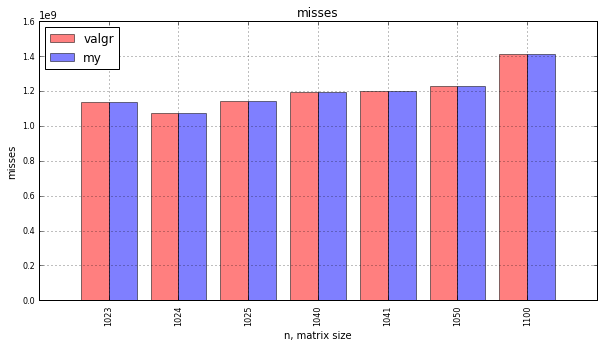

In [70]:
generate_plot(valgr_results, my_results, "misses")

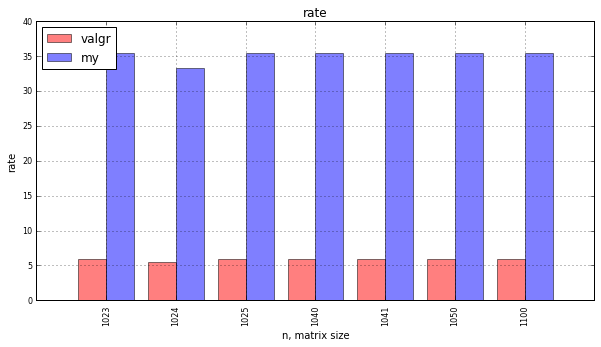

In [71]:
generate_plot(valgr_results, my_results, "rate")

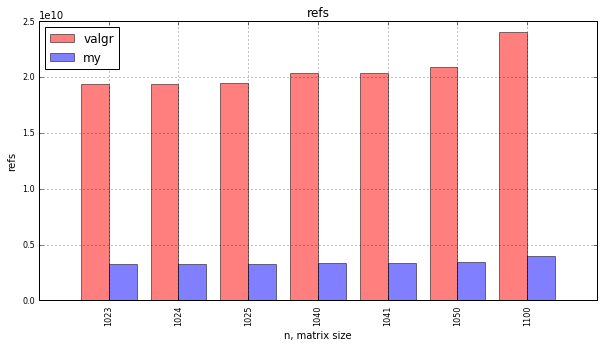

In [72]:
generate_plot(valgr_results, my_results, "refs")